In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pdb

%matplotlib inline
plt.rcParams['image.cmap'] = 'gist_gray'

In [14]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((train_images.shape[0], -1)).astype('float32')
test_images = test_images.reshape((test_images.shape[0], -1)).astype('float32')
train_images = train_images / np.max(train_images) # max = 225
test_images = test_images / np.max(test_images)    # max = 225

train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

# one hot encode the labels
num_classes = np.unique(train_labels).shape[0]
train_labels = tf.one_hot(train_labels, num_classes).numpy()
test_labels = tf.one_hot(test_labels, num_classes).numpy()

the label is 5


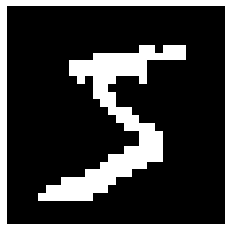

In [79]:
def show_images(images, rows, labels=None):
    rows = rows
    cols = int(images.shape[0]/rows)
    image_width = image_height = np.ceil(np.sqrt(images.shape[1])).astype(int)
    
#     plt.figure(figsize=(5, 5))
    gs = gridspec.GridSpec(rows, cols)
    gs.update(wspace=0.35, hspace=0.1)
    
    for i in range(images.shape[0]):
        axs = plt.subplot(gs[i])
        axs.axis('off')
        axs.set_xticklabels([])
        axs.set_yticklabels([])
        
        if labels is not None:
            axs.set_title(labels[i])
        
        axs.imshow(images[i].reshape([image_width, image_height]))

    
index = 0
sample_img = train_images[index]
show_images(np.array([sample_img]), 1)
print(f"the label is {tf.argmax(train_labels[index])}")

In [53]:
TRAIN_BUF = train_images.shape[0]
TEST_BUF = test_images.shape[0]
BATCH_SIZE = 200
seed = 101

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(TRAIN_BUF).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.shuffle(TEST_BUF).batch(BATCH_SIZE)

In [57]:
Gaussian_initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None)

class VAE(tf.keras.Model):
    def __init__(self, latent_dim, with_classifier=False):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.with_classifier = with_classifier
        
        # encoder function
        self.inference_net = tf.keras.Sequential(
            [
                tf.keras.layers.Input(shape=(784,)),
                tf.keras.layers.Dense(units=512, activation='relu', kernel_initializer=Gaussian_initializer),
                tf.keras.layers.Dense(units=256, activation='relu', kernel_initializer=Gaussian_initializer),
                tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer=Gaussian_initializer)
            ]
        )
        
        # mu(X)
        self.inference_mu = tf.keras.Sequential(
            [
                tf.keras.layers.Input(shape=(128,)),
                tf.keras.layers.Dense(units=latent_dim, kernel_initializer=Gaussian_initializer)
            ]
        )
        
        # sigma(X)
        self.inference_logvar = tf.keras.Sequential(
            [
                tf.keras.layers.Input(shape=(128,)),
                tf.keras.layers.Dense(units=latent_dim, kernel_initializer=Gaussian_initializer)
            ]
        )
        
        # decoder function
        self.generative_net = tf.keras.Sequential(
            [
                tf.keras.layers.Input(shape=(latent_dim,)),
                tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer=Gaussian_initializer),
                tf.keras.layers.Dense(units=256, activation='relu', kernel_initializer=Gaussian_initializer),
                tf.keras.layers.Dense(units=512, activation='relu', kernel_initializer=Gaussian_initializer),
                tf.keras.layers.Dense(units=784, kernel_initializer=Gaussian_initializer),
            ]
        )
        
        # classifier
        self.classifier = None
        if with_classifier:
            self.classifier = tf.keras.Sequential(
                [
                    tf.keras.layers.Input(shape=(latent_dim,)),
                    tf.keras.layers.Dense(units=256),
                    tf.keras.layers.Dense(units=256),
                    tf.keras.layers.Dense(units=10)
                ]
            )
    
    def encode(self, X):
        output = self.inference_net(X)
        mu = self.inference_mu(output)
        logvar = self.inference_logvar(output)
        return mu, logvar
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        
        if apply_sigmoid:
            return tf.sigmoid(logits)
        return logits
    
    def classify(self, z):
        if not self.with_classifier:
            raise Exception("Model was initialized without having a classifier")
        
        predict_labels = self.classifier(z)
        return predict_labels
    
    def reparameterize(self, mu, logvar):
        eps = tf.random.normal(shape=mu.shape)
        return mu + tf.sqrt(tf.exp(logvar)) * eps
    
    def sample(self, N):
        eps = tf.random.normal(shape=(N, self.latent_dim))
        sample_images = self.decode(eps, apply_sigmoid=True).numpy()
        
        if self.with_classifier:
            scores = self.classify(eps)
            sample_lables = tf.argmax(scores, axis=1).numpy()
            return sample_images, sample_lables
        else:
            return sample_images

In [58]:
def log_normal(sample, mu, logvar):
    log2pi = tf.math.log(2*np.pi)
    probs = -0.5 * (logvar + log2pi + (sample - mu)**2 * tf.exp(-logvar))
    return tf.reduce_sum(probs, axis=1)

def get_loss(model, batch_X):
    mu, logvar = model.encode(batch_X)
    z = model.reparameterize(mu, logvar)
    x_logits = model.decode(z)
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logits, labels=batch_X)
    logp_of_x_given_z = -tf.reduce_sum(cross_ent, axis=1)
    logp_of_z = log_normal(z, 0., 0.)
    logq_of_z_given_x = log_normal(z, mu, logvar)
#     pdb.set_trace()
    return -tf.reduce_mean(logp_of_x_given_z + logp_of_z - logq_of_z_given_x)

def get_gradients(model, x):
    with tf.GradientTape() as tape:
        loss = get_loss(model, x)
    return tape.gradient(loss, model.trainable_variables), loss

def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

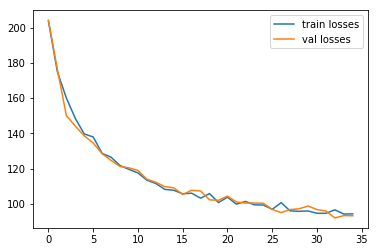

In [59]:
epochs = 35
latent_dim = 30
optimizer = tf.keras.optimizers.Adam(1e-4)
train_losses = []
val_losses = []
accuracy_size = 500

vae = VAE(latent_dim)

for e in range(epochs):
    for batch_X, batch_y in train_dataset:
        gradients, loss = get_gradients(vae, batch_X)
        apply_gradients(optimizer, gradients, vae.trainable_variables)
#         print(f"the loss is {loss}")
    
    train_index = np.random.choice(train_images.shape[0], accuracy_size)
    train_x = train_images[train_index]
    train_loss = get_loss(vae, train_x)
    
    val_index = np.random.choice(test_images.shape[0], accuracy_size)
    val_x = test_images[val_index]
    val_loss = get_loss(vae, val_x)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    

plt.plot(train_losses, label="train losses")
plt.plot(val_losses, label="val losses")
plt.legend()
plt.show()

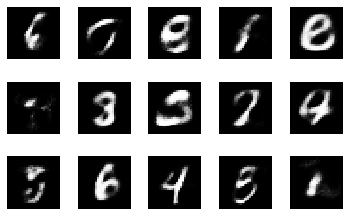

In [62]:
N_example = 15
sample = vae.sample(N_example)
show_images(sample, 3)

In [75]:
def get_loss_with_classifier(model, X, y):
    mu, logvar = model.encode(X)
    z = model.reparameterize(mu, logvar)
    x_logits = model.decode(z)
    
    y_scores = model.classify(z)
    classifier_loss = tf.nn.softmax_cross_entropy_with_logits(logits=y_scores, labels=y)
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logits, labels=X)
    logp_of_x_given_z = -tf.reduce_sum(cross_ent, axis=1)
    logp_of_z = log_normal(z, 0., 0.)
    logq_of_z_given_x = log_normal(z, mu, logvar)
#     pdb.set_trace()
    return -tf.reduce_mean(logp_of_x_given_z + logp_of_z - logq_of_z_given_x) + tf.reduce_mean(classifier_loss)

def get_gradients_with_classifier(model, x, y):
    with tf.GradientTape() as tape:
        loss = get_loss_with_classifier(model, x, y)
    return tape.gradient(loss, model.trainable_variables), loss

def apply_gradients_with_classifier(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))
    
def get_classification_accuracy(model, X, y):
    mu, logvar = model.encode(X)
    z = model.reparameterize(mu, logvar)
    y_scores = model.classify(z)
    matches = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_scores, axis=1))
    matches = tf.cast(matches, dtype=tf.float32)
    return tf.reduce_mean(matches).numpy()

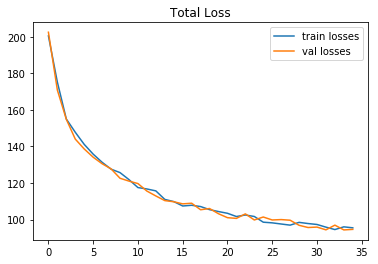

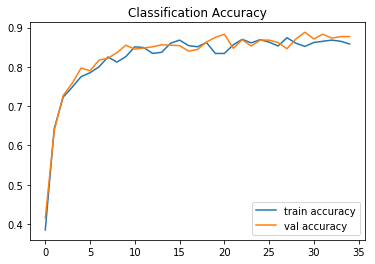

In [83]:
epochs = 35
latent_dim = 30
optimizer = tf.keras.optimizers.Adam(1e-4)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
accuracy_size = 1000

vae_with_classifier = VAE(latent_dim, with_classifier=True)

for e in range(epochs):
    for batch_X, batch_y in train_dataset:
        gradients, loss = get_gradients_with_classifier(vae_with_classifier, batch_X, batch_y)
        apply_gradients_with_classifier(optimizer, gradients, vae_with_classifier.trainable_variables)
#         print(f"the loss is {loss}")
    
    train_index = np.random.choice(train_images.shape[0], accuracy_size)
    train_x = train_images[train_index]
    train_y = train_labels[train_index]
    train_loss = get_loss_with_classifier(vae_with_classifier, train_x, train_y)
    train_accuracy = get_classification_accuracy(vae_with_classifier, train_x, train_y)
    
    val_index = np.random.choice(test_images.shape[0], accuracy_size)
    val_x = test_images[val_index]
    val_y = test_labels[val_index]
    val_loss = get_loss_with_classifier(vae_with_classifier, val_x, val_y)
    val_accuracy = get_classification_accuracy(vae_with_classifier, val_x, val_y)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    

plt.plot(train_losses, label="train losses")
plt.plot(val_losses, label="val losses")
plt.title("Total Loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, label="train accuracy")
plt.plot(val_accuracies, label="val accuracy")
plt.title("Classification Accuracy")
plt.legend()
plt.show()

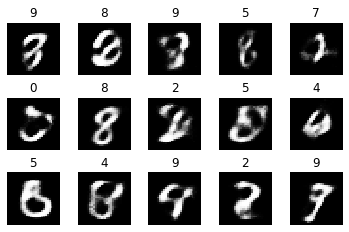

In [84]:
generated_images, generated_labels = vae_with_classifier.sample(15)
show_images(generated_images, 3, labels=generated_labels)